## Dataset loading

In [2]:
import pandas as pd
import numpy as np
import torch
import os
from utils import data

dataset_path = './dataset/'
dataset_files = ['TcData.csv' ,'BsData.csv']

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    #"device": torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"),
}
pd.set_option("display.max_columns", None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

dfs = dict([])
for file in dataset_files:
    df = pd.read_csv(os.path.join(dataset_path,file), na_values=0)
    df = df.rename(columns={'Composition': 'formula'})
    df = data.featurize_data(df,load_existing_df=True, pkl_path = os.path.join(dataset_path, f"./df_data_{file[:2]}.pkl"))
    df.name = file[:2]
    dfs[df.name] = df

## Surrogate definition

I wrote this surrogate class to handle heavy utility function and analysis work. We are choosing to drop all three features: annealing temp, time, and thickness for later use in infering only in FeBSiP composition.

In [3]:
from utils.surrogate import surrogate_model

Tc_surrogate = surrogate_model(name='Tc', df=dfs['Tc'])
Bs_surrogate = surrogate_model(name='Bs', df=dfs['Bs'])

Tc_surrogate.cleanup_df(drop_NaN = False, 
                        drop_col_with_NaN = True,
                        drop_thickness=True)
Bs_surrogate.cleanup_df(drop_NaN = False, 
                        drop_col_with_NaN = True,
                        drop_thickness=True)

surrogates = [Tc_surrogate, Bs_surrogate] 

#GPR Model definition and training

Assign training data and target then train them.

In [4]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
#from botorch.fit import fit_gpytorch_mll
from torch.optim import SGD, Adam
from botorch.models.transforms.input import ChainedInputTransform
from utils.model import trainGP, NormalizeElementFractions, NormalizeFeatures
from utils.model import test_features_normalized

def initialize_model(X,y):

    outcome_transform = Standardize(m=1)
    normalize_other = NormalizeFeatures(indices=surrogates[0].to_scale_col)
    normalize_EF = NormalizeElementFractions(indices=surrogates[0].EF_col)
    input_transform = ChainedInputTransform(
        #tf1=normalize_other, 
        tf2=normalize_EF,
    )
    model = SingleTaskGP(
        train_X = X, 
        train_Y = y,
        input_transform = input_transform,
    outcome_transform =outcome_transform,
    covar_module = ScaleKernel(RBFKernel()),
    )
    return model

for surrogate_model in surrogates:
    surrogate_model.model = None
    #make sure the dims are n_entries x n_features for 1 obj
    surrogate_model.model = initialize_model(torch.tensor(surrogate_model.X), 
                                             torch.tensor(surrogate_model.y).unsqueeze(dim=-1)
                                            )
    print("-------------------")
    surrogate_model.model.train()
    trainGP(surrogate_model.model)

-------------------
Epoch  50/200 - Loss: 0.814 noise: 0.320
Epoch 100/200 - Loss: 0.583 noise: 0.087
Epoch 150/200 - Loss: 0.582 noise: 0.086
Epoch 200/200 - Loss: 0.582 noise: 0.086
-------------------
-------------------
Epoch  50/200 - Loss: 1.000 noise: 0.400
Epoch 100/200 - Loss: 0.888 noise: 0.183
Epoch 150/200 - Loss: 0.870 noise: 0.185
Epoch 200/200 - Loss: 0.867 noise: 0.184
-------------------


# MOBO using dev API to solve for a reduced-feature surrogate model 

See comments in full_cycle-3p for step by step guide

In [5]:
import numpy as np
import pandas as pd
from ax.core.data import Data
from ax.core.experiment import Experiment
from ax.core.metric import Metric
from ax.core.objective import MultiObjective, Objective
from ax.core.optimization_config import (
    MultiObjectiveOptimizationConfig,
    ObjectiveThreshold,
)

from ax.core.parameter import ParameterType, RangeParameter
from ax.core.search_space import SearchSpace

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume
from ax.modelbridge.registry import Models
from ax.runners.synthetic import SyntheticRunner
from ax.service.utils.report_utils import exp_to_df

In [6]:
from utils.model import evaluateGP
selected = ['Fe', 'B', 'Si', 'P']

values = [i for i,col in enumerate(surrogates[0].X_label) if col in selected]
keys = surrogates[0].X_label[values]
feature_to_idx = {key: value for key, value in zip(keys, values)}

x_to_ER = {'x0': 'Fe', 'x1':'B'}
set_features = {'Si': 0.05, 'P': 0.03}

In [7]:
x0 = RangeParameter(name="x0", lower=0, upper=1, parameter_type=ParameterType.FLOAT)

search_space = SearchSpace(parameters=[x0])

In [8]:
from utils.metric import GP_metric

class custom_metric(GP_metric):
    def evaluate(self, params) -> float:
        new_params = {'x0': params['x0'],'x1': 1-params['x0'],}
        X = self.params_to_X(new_params)
        return evaluateGP(self.model, X.numpy())

metric_kwargs = {
    'lower_is_better': False,
    'feature_to_idx': feature_to_idx, 
    'x_to_ER': x_to_ER,             
    'set_features': set_features
}
#define how to calculate Tc, Bs (use prev trained GP models)
metric_Tc = custom_metric(name = "Tc", 
                      model=surrogates[0].model,
                      n_features=surrogates[0].X.shape[1],
                      **metric_kwargs)
metric_Bs = custom_metric(name = "Bs", 
                      model=surrogates[1].model,
                      n_features=surrogates[1].X.shape[1],
                      **metric_kwargs)

In [9]:
ref_point = torch.tensor([np.average(surrogate.y) for surrogate in surrogates],**tkwargs)
mo = MultiObjective(
    objectives=[Objective(metric=metric_Tc), Objective(metric=metric_Bs)],
)

objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, ref_point)
]

optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

In [10]:
# Reasonable defaults for number of quasi-random initialization points and for subsequent model-generated trials.
N_INIT = 25

def build_experiment():
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

## Initialize with Sobol samples
def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space, seed=1234)
    for _ in range(N_INIT):
        experiment.new_trial(sobol.gen(1)).run()
    return experiment.fetch_data()

sobol_experiment = build_experiment()
sobol_data = initialize_experiment(sobol_experiment)

In [11]:
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.acquisition.logei import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
)

from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.parego import qLogNParEGO

def initialize_sobol_generator(experiment, data):
    sobol_gen = Models.SOBOL(
        experiment=experiment,
        data=sobol_data,
    )
    return sobol_gen

def initialize_botorch_model(run_name, experiment, data):
    if run_name=='Sobol':
        GP_model = Models.BOTORCH_MODULAR(
            # Optional `Surrogate` specification to use instead of default
            experiment=experiment,
            data=data,
            surrogate=Surrogate(
                # BoTorch `Model` type
                botorch_model_class=SingleTaskGP,
                outcome_transform_classes= [Standardize],
                outcome_transform_options= {'Standardize': {"m":2}},
                covar_module_class = ScaleKernel,
                covar_module_options = {'base_kernel': RBFKernel()},
            ),
            transforms=None,
            # Optional BoTorch `AcquisitionFunction` to use instead of default
            #botorch_acquisition=qLogNParEGO
        )
    else:
        GP_model = Models.BOTORCH_MODULAR(
        # Optional `Surrogate` specification to use instead of default
        experiment=experiment,
        data=data,
        surrogate=Surrogate(
            # BoTorch `Model` type
            botorch_model_class=SingleTaskGP,
            outcome_transform_classes= [Standardize],
            outcome_transform_options= {'Standardize': {"m":2}},
            covar_module_class = ScaleKernel,
            covar_module_options = {'base_kernel': RBFKernel()},
        ),
        transforms=None,
        # Optional BoTorch `AcquisitionFunction` to use instead of default
        botorch_acquisition=qLogNParEGO
    )
    
    return GP_model

def start_exp():
    experiment = build_experiment()
    data = initialize_experiment(experiment)
    return experiment, data

In [12]:
def ehvi_model(experiment, data):
    GP_model = Models.BOTORCH_MODULAR(
                # Optional `Surrogate` specification to use instead of default
                experiment=experiment,
                data=data,
                surrogate=Surrogate(
                    # BoTorch `Model` type
                    botorch_model_class=SingleTaskGP,
                    outcome_transform_classes= [Standardize],
                    outcome_transform_options= {'Standardize': {"m":2}},
                    covar_module_class = ScaleKernel,
                    covar_module_options = {'base_kernel': RBFKernel()},
                ),
                transforms=None,
                # Optional BoTorch `AcquisitionFunction` to use instead of default
                botorch_acqf_class=qLogNoisyExpectedHypervolumeImprovement
            )
    return GP_model

def run_BO_ehvi(N_BATCH):
    experiment, data = start_exp()
    model = None
    hv_list = []
    for i in range(N_BATCH):

        model = ehvi_model(experiment, data)
        generator_run = model.gen(1)
        trial = experiment.new_trial(generator_run=generator_run)
        trial.run()
        data = Data.from_multiple_data([data, trial.fetch_data()])
        exp_df = exp_to_df(experiment)
        try:
            hv = observed_hypervolume(modelbridge=model)
        except:
            hv = 0
            print("Failed to compute hv")
        hv_list.append(hv)
        #print(f"Iteration: {i}, HV: {hv}")
    return experiment, data, model, hv_list

In [13]:
def add_to_dict(BO_results, results_order = ['experiment', 'data', 'model', 'hv_list']):
    d = {}
    for i, k in enumerate(results_order):
        d[k] = BO_results[i]
    return d

results = {}

NBATCH = 50
results['ehvi'] = add_to_dict(run_BO_ehvi(NBATCH))

[WARNING 09-09 00:58:18] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.
[WARNING 09-09 00:58:19] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.
/Users/ktrerayapiwat/miniconda3/envs/matminer-Ax/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[WARNING 09-09 00:58:20] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.
/Users/ktrerayapiwat/miniconda3/envs/matminer-Ax/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[WARNING 09-09 00:58:20] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.
/Users/ktrerayapiwat/miniconda3/envs/matminer-Ax/lib/python3.10/site-packages/botorch/optim/optimize.py:564: RuntimeWarning: Optim

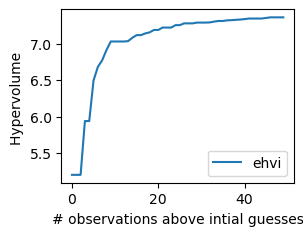

In [14]:
import matplotlib.pyplot as plt

ehvi_hv_list = results['ehvi']['hv_list']

fig, ax = plt.subplots(figsize=[3,2.25])
ax.plot(np.arange(len(ehvi_hv_list)), ehvi_hv_list,label='ehvi')

ax.set_ylabel('Hypervolume ')
ax.set_xlabel('# observations above intial guesses')
ax.legend(loc='lower right')
plt.show()

## Starting Bayesian inference to find Fe distribution posterior

- First get spread of Fe among composition containing ['Fe', 'B', 'Si', 'P']. This is our observation
- Define Fe spread starting with a uniform from 0 to 1 before convoluting to a truncated Gaussian. This is our prior. It is appropriate prior.
- Use MC to calculate posterior

In [16]:
import pymc as pm
#from arziv import plot_trace
subset = ['Fe', 'B', 'Si', 'P']
df_subset = data.subset_df_by_elements(Bs_surrogate.df, subset)

Fe_dist = df_subset['Fe'].values

In [17]:
from utils.data import describe_non_zero_mean
describe_non_zero_mean(df_subset)

,Bs (T),B,C,Al,Si,P,Cr,Fe,Co,Ni,Cu,Ga,Nb,Mo,Sn
count,126.000000,126.000000,59.000000,7.00,126.000000,126.000000,2.00,126.000000,15.000000,5.000000,64.000000,7.000000,6.000000e+00,2.00,3.00
mean,1.636529,0.086352,0.025905,0.04,0.026538,0.039580,0.02,0.802006,0.112400,0.234000,0.008648,0.034286,2.300000e-02,0.02,0.02
std,0.219612,0.025489,0.014873,0.00,0.011808,0.030571,0.00,0.084334,0.082733,0.123329,0.002276,0.009759,3.800589e-18,0.00,0.00
min,0.880000,0.039600,0.005000,0.04,0.005000,0.010000,0.02,0.390000,0.040000,0.078000,0.005000,0.020000,2.300000e-02,0.02,0.02
25%,1.611988,0.080000,0.012500,0.04,0.020000,0.027500,0.02,0.812000,0.040000,0.156000,0.007000,0.030000,2.300000e-02,0.02,0.02
50%,1.680000,0.090000,0.020000,0.04,0.027500,0.030000,0.02,0.830800,0.073000,0.234000,0.007500,0.040000,2.300000e-02,0.02,0.02
75%,1.809897,0.100000,0.039800,0.04,0.040000,0.040000,0.02,0.840000,0.169000,0.312000,0.010000,0.040000,2.300000e-02,0.02,0.02
max,1.850890,0.142000,0.060000,0.04,0.055000,0.120000,0.02,0.850000,0.292000,0.390000,0.015000,0.040000,2.300000e-02,0.02,0.02


In [18]:
with pm.Model() as MC_model:
    Fe_avg = pm.Uniform("mu", 0,1)
    Fe_spread = pm.Uniform("sigma", 0,1)
    Fe_frac = pm.TruncatedNormal(
        'random_Fe',
        mu=Fe_avg,
        sigma = Fe_spread,
        lower=0,
        upper=1,
        observed = Fe_dist
    )
    MC_trace = pm.sample(5000, tune=2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 2 seconds.


# plot important metrics to assess success of inference
mu, sigma posteriordistribution trace and the corner plot

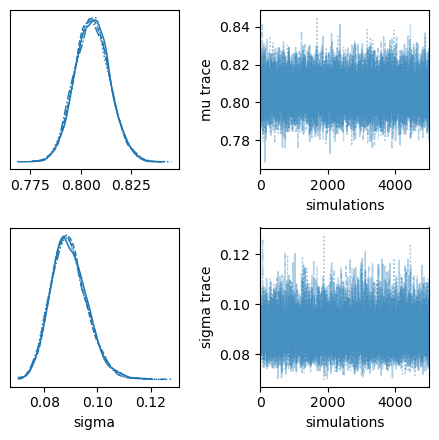

In [19]:
from arviz import plot_trace
plot_trace(MC_trace)
fig = plt.gcf()
fig.set_size_inches([4.5,4.5])

axes = fig.get_axes()
axes[0].set_title('')
axes[1].set_xlabel('sigma')

axes[1].set_title('')
axes[1].set_xlabel('simulations')
axes[1].set_ylabel('mu trace')


axes[2].set_title('')
axes[2].set_xlabel('sigma')

axes[3].set_title('')
axes[3].set_xlabel('simulations')
axes[3].set_ylabel('sigma trace')

fig.tight_layout()
fig.savefig('./imgs/trace_plot.png', dpi=300)

No correlation between the mean and std dev. We do not expect correlation between these two independent parameters

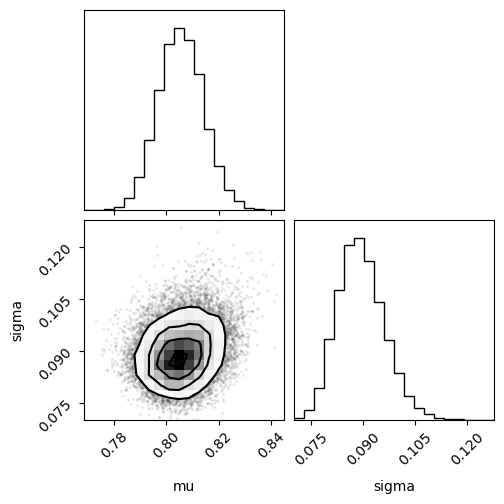

In [20]:
import corner 
figure = corner.corner(MC_trace,divergence=True)

In [21]:
from scipy.stats import beta

post_pred = pm.sample_posterior_predictive(
    trace=MC_trace,
    model = MC_model,
    var_names=['random_Fe']
    
)

Sampling: [random_Fe]


Output()

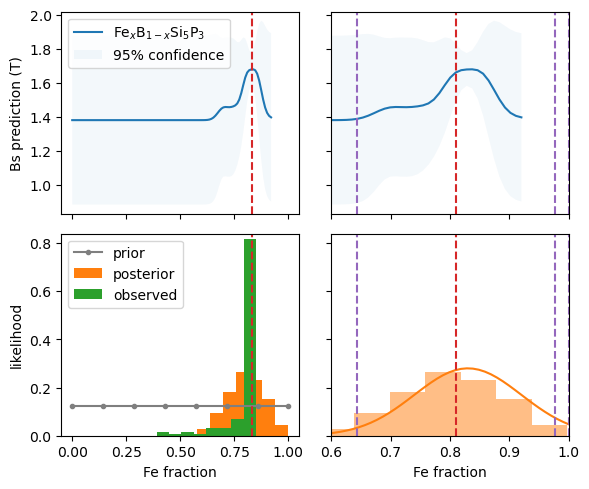

In [22]:
Fe_grid = np.linspace(0,1,101)

predicted_Bs = []
predicted_Bs_sigma = []
for x in Fe_grid:
    #X = torch.tensor([Fe], **tkwargs).unsqueeze(0)
    #means, sems = evaluateGP(results['ehvi']['model'].model.surrogate.model,X)
    #x0 = Fe
    mean, sem = metric_Bs.evaluate({'x0': x})
    #print(means)
    predicted_Bs.append(mean)
    predicted_Bs_sigma.append(sem)

Fe_grid2 = Fe_grid *92/100

predicted_Bs = np.array(predicted_Bs)
predicted_Bs_sigma = np.array(predicted_Bs_sigma)

fig, axes = plt.subplots(2,2, figsize=[6,5], sharex='col', sharey='row')

axes[0,0].plot(Fe_grid2,predicted_Bs, label = r'Fe$_x$B$_{1-x}$Si$_5$P$_3$')
axes[0,0].fill_between(Fe_grid2, 
                 predicted_Bs-2*predicted_Bs_sigma, 
                 predicted_Bs+2*predicted_Bs_sigma,
                 alpha = 0.05, label = '95% confidence')
axes[0,0].axvline(x=0.83, linestyle='--',color='tab:red')
axes[0,0].set_ylabel('Bs prediction (T)')
axes[0,0].legend(loc='upper left')


grid1 = np.linspace(0, 1.0, 8)
grid = np.linspace(0, 1.0, 8)
# Varying positional arguments

prior = np.ones(len(grid1))
posterior = np.array(post_pred.posterior_predictive.data_vars['random_Fe'][0,0::300]).ravel()
counts_p, bins_p = np.histogram(posterior,bins=8)
observed = Fe_dist
counts_o, bins_o = np.histogram(observed,bins=8)
#posterior /= np.sum(posterior)
#prior = prior/prior.max() * 720
#


axes[1,0].plot(grid1, prior/np.sum(prior), ".-", label='prior', color ='tab:grey')
#ax.hist(posterior, bins=18, label='posterior')
axes[1,0].stairs(counts_p/np.sum(counts_p), bins_p, label='posterior', fill=True, color ='tab:orange')
axes[1,0].stairs(counts_o/np.sum(counts_o), bins_o, label='observed', fill=True, color ='tab:green')
#ax.hist(observed, bins=18, label='observed')
axes[1,0].legend()
axes[1,0].set_xlabel('Fe fraction')
axes[1,0].set_ylabel('likelihood')
axes[1,0].axvline(x=0.83, linestyle='--',color='tab:red')
#fig.savefig('bayesian_inference.png', dpi=300)
#plt.show()



axes[0,1].plot(Fe_grid2,predicted_Bs)
axes[0,1].fill_between(Fe_grid2, 
                 predicted_Bs-2*predicted_Bs_sigma, 
                 predicted_Bs+2*predicted_Bs_sigma,
                 alpha = 0.05)
axes[0,1].axvline(x=0.81, linestyle='--',color='tab:red')
axes[0,1].axvline(x=0.81-0.083*2, linestyle='--',color='tab:purple')
axes[0,1].axvline(x=0.81+0.083*2, linestyle='--',color='tab:purple')
axes[0,1].axvline(x=1, linestyle='--',color='tab:purple')
axes[0,1].set_xlim([0.6,1])
#axes[0,1].set_ylabel('Bs prediction (T)')


grid1 = np.linspace(0, 1.0, 8)
grid = np.linspace(0, 1.0, 8)
# Varying positional arguments

prior = np.ones(len(grid1))
posterior = np.array(post_pred.posterior_predictive.data_vars['random_Fe'][0,0::300]).ravel()
counts_p, bins_p = np.histogram(posterior,bins=8)
observed = Fe_dist
counts_o, bins_o = np.histogram(observed,bins=8)
#posterior /= np.sum(posterior)
#prior = prior/prior.max() * 720
#

grid2 = np.linspace(0, 1.0, 100)
mu = 0.83
sigma = 0.09
# Varying positional arguments

def gaussian(x, mu, sig):
    y = 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    y[x>1.0] = 0
    y[x<0.0] = 0
    return y
y = gaussian(grid2, mu, sigma)
norm = 0.28
axes[1,1].stairs(counts_p/np.sum(counts_p), bins_p, label='posterior', fill=True, alpha=0.5, color ='tab:orange')
axes[1,1].plot(grid2, y/np.max(y) * norm, "-", label='prior', color ='tab:orange')
axes[1,1].set_xlabel('Fe fraction')
#axes[1,1].set_ylabel('likelihood')
axes[1,1].set_xlim([0.6,1])
axes[1,1].set_ylim([0,0.84])
axes[1,1].axvline(x=0.81, linestyle='--',color='tab:red')
axes[1,1].axvline(x=0.81-0.083*2, linestyle='--',color='tab:purple')
axes[1,1].axvline(x=0.81+0.083*2, linestyle='--',color='tab:purple')
axes[1,1].axvline(x=1, linestyle='--',color='tab:purple')
fig.tight_layout()
fig.savefig('./imgs/bayesian_inference.png', dpi=300)
#plt.show()